In [1]:
import torch.nn as nn
import torch
import os
import matplotlib.pyplot as plt

from train import train, eval
from models import *
import json
from loss import leakage_loss, leakage_loss_simple
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, data_fn, x_num, c_num, y_num):
        self.data = torch.load(data_fn, weights_only=True)
        self.x_num = x_num
        self.c_num = c_num
        self.y_num = y_num

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx,:self.x_num].float(), self.data[idx,-self.c_num:], self.data[idx,self.x_num]
    

class BinarySigmoid(nn.Module):
    def __init__(self):
        super(BinarySigmoid, self).__init__()

    def __repr__(self):
        return 'BinarySigmoid()'

    def forward(self, x):
        return torch.round(torch.nn.functional.sigmoid(x))

In [93]:
config_file = "experiment_results_16_concepts.json"
expr_name = "latentCBM"
with open(config_file) as json_file:
    config = json.load(json_file)[expr_name]['config']
config_map = {}
config_map["nn.Sigmoid()"] = nn.Sigmoid()
config_map["nn.Softmax(dim=1)"] = nn.Softmax(dim=1)
config_map["nn.CrossEntropyLoss()"] = nn.CrossEntropyLoss()
config_map["nn.BCELoss()"] = nn.BCELoss()
config_map["leakage_loss_simple"] = leakage_loss_simple
config_map["BinarySigmoid()"] = BinarySigmoid()
config_map[""] = None

In [94]:
# Loading the Data
dataset = SyntheticDataset(config["data_fn"], config["x_num"], config["c_num"], config["y_num"])
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)

In [95]:
x_to_c_model = XtoCModel(config["x_num"], config["c_num"], config["l_num"], depth=config["xc_depth"], width=config["xc_width"],
                         use_relu=config["xc_use_relu"], use_sigmoid=config["xc_use_sigmoid"], 
                         final_activation=config_map[config["xc_final_activation"]]).to(device)
c_to_y_model = CtoYModel(config["c_num"]+config["l_num"], config["y_num"], depth=config["cy_depth"], width=config["cy_width"],
                         use_relu=config["cy_use_relu"], use_sigmoid=config["cy_use_sigmoid"], 
                         final_activation=config_map[config["cy_final_activation"]]).to(device)
model = FullModel(x_to_c_model, c_to_y_model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
print(model)

FullModel(
  (x_to_c_model): XtoCModel(
    (activation_func): ReLU()
    (linears): ModuleList(
      (0): Linear(in_features=54, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=16, bias=True)
    )
    (final_activation): Sigmoid()
  )
  (c_to_y_model): CtoYModel(
    (activation_func): ReLU()
    (linears): ModuleList(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=7, bias=True)
    )
    (final_activation): Softmax(dim=1)
  )
)


In [96]:
losses, accuracies, concept_accuracy = train(model, train_loader, config["c_num"], optimizer, y_criterion=config_map[config["y_criterion"]],
            concept_criterion=config_map[config["c_criterion"]], latent_criterion=config_map[config["l_criterion"]], loss_norm=config["loss_norm"], epochs=config["epochs"], device=device)

Total Loss: 0.0018 Label Loss: 0.0007 Label Accuracy: 0.7171 Concept Loss: 0.0011 Concept Accuracy: 0.9480 Latent Loss: 0.0000: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


In [97]:
test_loss, test_accuracy, test_concept_accuracy, test_label_loss, test_concept_loss, test_latent_loss, f1_score_meter, precision, recall, rocauc = eval(model, test_loader, config["c_num"], y_criterion=config_map[config["y_criterion"]],
            concept_criterion=config_map[config["c_criterion"]], latent_criterion=config_map[config["l_criterion"]], loss_norm=config["loss_norm"], device=device)

results = {"Loss": test_loss, "Label Accuracy": test_accuracy, "Label Loss": test_label_loss, "Concept Accuracy": test_concept_accuracy, 
           "Concept Loss": test_concept_loss, "Latent Loss": test_latent_loss}
with open(config_file) as json_file:
    json_dict = json.load(json_file)

json_dict[expr_name]['results'] = results
with open(config_file, "w") as file:
    json.dump(json_dict, file, indent=4)

Test Results:
Loss: 0.0028, Label Accuracy: 0.6970, Concept Accuracy: 0.9471
Label Loss: 0.0017, Concept Loss: 0.0011 Latent Loss: 0.0000
F1 Score: 0.0000, Precision: 0.0000, Recall: 0.0000, ROCAUC: 0.0000


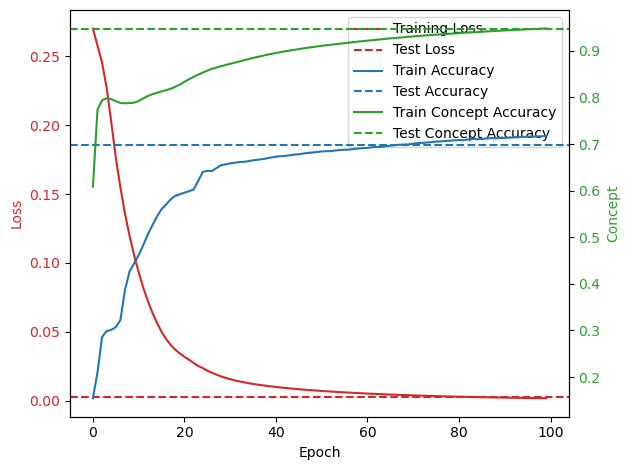

In [98]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1_train_loss = ax1.plot(range(len(losses)), losses, color=color, label="Training Loss")
ax1_test_loss = ax1.axhline(y = test_loss, color = color, linestyle = 'dashed', label="Test Loss") 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2_train_accuracy = ax2.plot(range(len(accuracies)), accuracies, color=color, label="Train Accuracy")
ax2_test_accuracy = ax2.axhline(y = test_accuracy, color = color, linestyle = 'dashed', label="Test Accuracy") 
ax2.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a third Axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Concept', color=color)  # we already handled the x-label with ax1
ax2_train_concept_accuracy = ax2.plot(range(len(concept_accuracy)), concept_accuracy, color=color, label="Train Concept Accuracy")
ax2_test_concept_accuracy = ax2.axhline(y = test_concept_accuracy, color = color, linestyle = 'dashed', label="Test Concept Accuracy") 
ax2.tick_params(axis='y', labelcolor=color)

plots = ax1_train_loss+[ax1_test_loss]+ax2_train_accuracy+[ax2_test_accuracy]+ax2_train_concept_accuracy+[ax2_test_concept_accuracy]
labs = [l.get_label() for l in plots]
ax1.legend(plots, labs)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()